In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
allTrain=pd.read_csv('train.csv')
allTrain.isnull().any()

shot_id              False
action_type          False
lat                  False
loc_x                False
loc_y                False
lon                  False
minutes_remaining    False
period               False
playoffs             False
season               False
seconds_remaining    False
shot_distance        False
shot_made_flag        True
shot_zone_area       False
game_date            False
opponent             False
dtype: bool

In [63]:
Traindata=allTrain.copy()
Traindata['shot_made_flag'][Traindata['shot_made_flag'].isnull()]=0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(-50, 900)

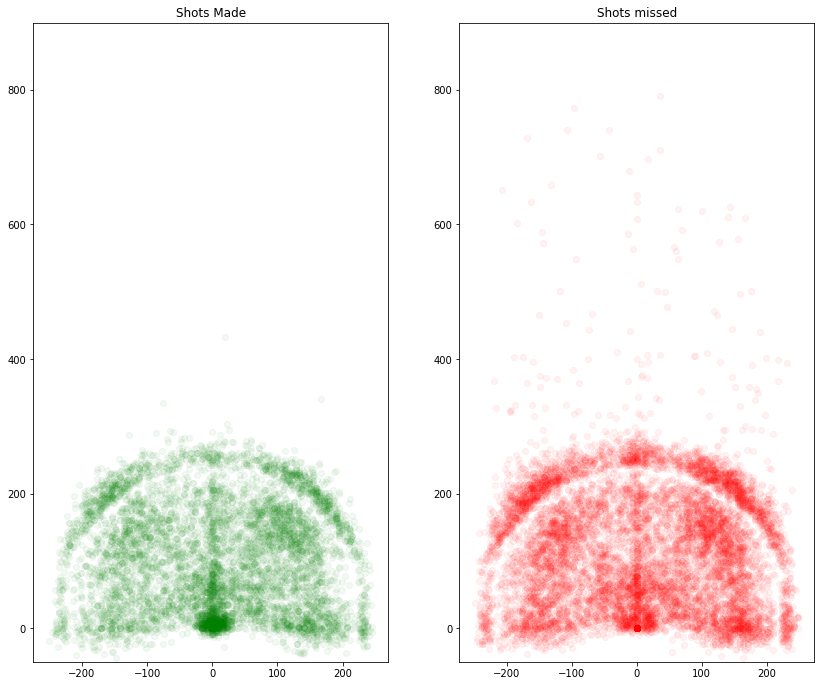

In [4]:
# Court visualization of misses and shots
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# hit
plt.subplot(121)
h = Traindata.loc[Traindata.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha=alpha)
plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
h = Traindata.loc[Traindata.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=alpha)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])


Notice the red dot at where the basket should be? He misses a lot of shots from under the basket. Must be those common ball scenarios.

In [5]:
Traindata['action_type'].unique().shape

(54,)

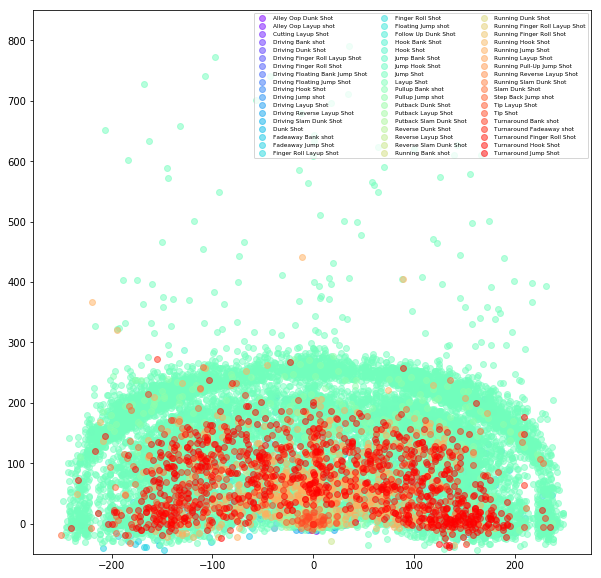

In [6]:
#action type v.s. shot location
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
plt.ylim((-50,850))

def scatter_plot_by_category(data,feat):
    alpha = 0.5
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha,label=g[0])
    
scatter_plot_by_category(Traindata,'action_type')
plt.legend(ncol=3,fontsize='xx-small')


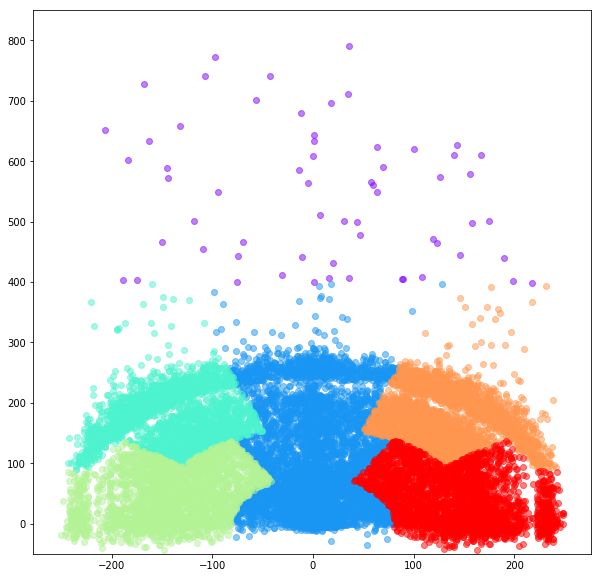

In [7]:
#shot zone area
plt.figure(figsize=(10,10))
plt.ylim((-50,850))
scatter_plot_by_category(Traindata,'shot_zone_area')

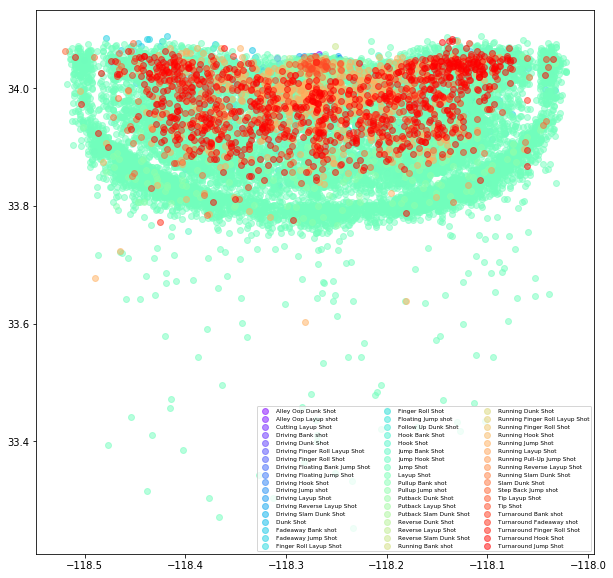

In [8]:
#action_type v.s. shot lon and lat
import matplotlib.cm as cm
plt.figure(figsize=(10,10))

def scatter_plot_by_category_(data,feat):
    alpha = 0.5
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].lon, g[1].lat, color=c, alpha=alpha,label=g[0])
    
scatter_plot_by_category_(Traindata,'action_type')
plt.legend(ncol=3,fontsize='xx-small')

'loc_x','loc_y' and 'lon','lat' can be saied the same, so we can just choose one set of these to be needed features. 

but we still can try "polar coordinate" to place these two sets, because distance and angle may be more representative.

In [64]:
#polar coodinate: angle and dist
Traindata['dist'] = np.sqrt(Traindata['loc_x']**2 + Traindata['loc_y']**2)

loc_x_zero = Traindata['loc_x'] == 0
Traindata['angle'] = np.array([0]*len(Traindata))
Traindata['angle'][~loc_x_zero] = np.arctan(Traindata['loc_y'][~loc_x_zero] / Traindata['loc_x'][~loc_x_zero])
Traindata['angle'][loc_x_zero] = np.pi / 2 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [65]:
#cluster the shot attempts of kobe using GMM on their location
from sklearn import mixture

numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(Traindata.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
Traindata['shotLocationCluster'] = gaussianMixtureModel.predict(Traindata.loc[:,['loc_x','loc_y']])

In [87]:
act_type=Traindata.action_type.unique()

In [88]:
#Transfer the action types of kobe to integer values
act_ind=dict(zip(act_type,np.arange(len(act_type))))
Traindata['act_ind']=Traindata['action_type'].map(act_ind)

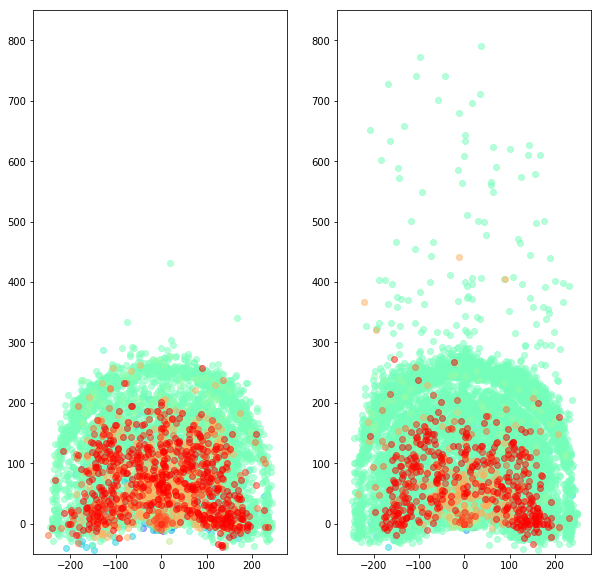

In [12]:
#action type v.s. made or missed
madeit=Traindata[Traindata['shot_made_flag']==1]
not_madeit=Traindata[Traindata['shot_made_flag']==0]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.ylim((-50,850))
scatter_plot_by_category(madeit,'action_type')
plt.subplot(1,2,2)
plt.ylim((-50,850))
scatter_plot_by_category(not_madeit,'action_type')

In [13]:
print('the number of action types that making ball fall in: ',madeit.action_type.unique().shape[0])
print('the number of action types that \'not\' making ball fall in: ',not_madeit.action_type.unique().shape[0])

the number of action types that making ball fall in:  53
the number of action types that 'not' making ball fall in:  47


From above, we can know that action types are different with shot position and related with whether fall in or not.

Therefore, we may need shot_made_flag to be needed features.

In [67]:
Traindata['secondsFromPeriodEnd']   = 60*Traindata['minutes_remaining']+Traindata['seconds_remaining']
Traindata['secondsFromPeriodStart'] = 60*(11-Traindata['minutes_remaining'])+(60-Traindata['seconds_remaining'])
Traindata['secondsFromGameStart']   = (Traindata['period'] <= 4).astype(int)*(Traindata['period']-1)*12*60 + (Traindata['period'] > 4).astype(int)*((Traindata['period']-5)*5*60 + 4*12*60) + Traindata['secondsFromPeriodStart']

Traindata.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,4,4,59,2581
1,3,1,52,2048
2,3,2,5,2035
3,3,8,54,1626
4,4,4,29,2611
5,4,11,46,2174
6,3,10,44,1516
7,4,7,57,2403
8,1,7,53,247
9,4,3,39,2661


In [68]:
Traindata['action_first_words'] = Traindata.action_type.str.split(' ').str[0]
action=Traindata['action_first_words'].unique()

Text(0.5,0,'time [seconds from start of game]')

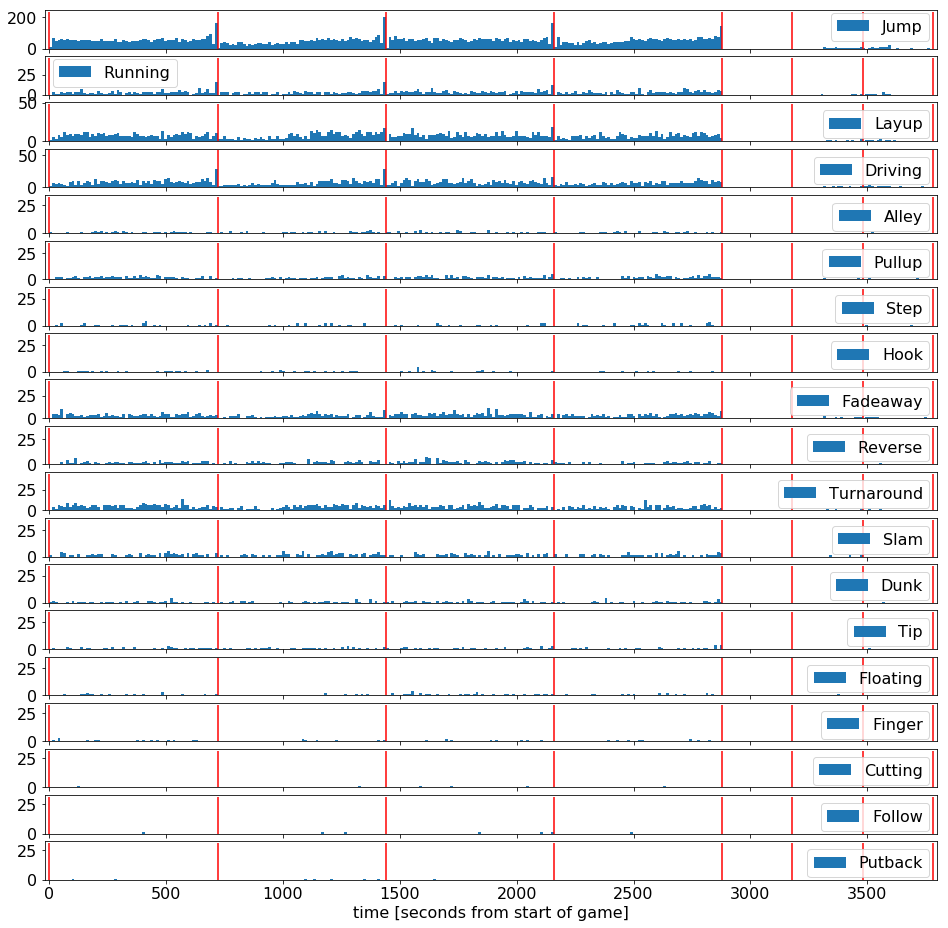

In [16]:
#action type v.s. time from game start
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binSizes = 12

plt.figure();
for i, act in enumerate(action): 
    timeBins = np.arange(0,60*(4*12+3*5),binSizes)+0.01
    ActTypeAsFunctionOfTime, b = np.histogram(Traindata.loc[Traindata['action_first_words']==act,'secondsFromGameStart'], bins=timeBins)     
    maxHeight = max(ActTypeAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(action),1,i+1); 
    plt.bar(timeBins[:-1],ActTypeAsFunctionOfTime, align='edge', width=barWidth,label=act)
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight,colors='r')
    plt.xlim((-20,3800));
    plt.legend()
plt.xlabel('time [seconds from start of game]')

Kobe likes making some specific action types.

We can see that there are differences in action types with time, for example, some type attempts won't change along time passing but some will, and he likes to make some action type in specific time.

we can know his shot attempts increase a lot when time is about to over, and his action type-time pattern are similar in almost every period of every type besides in the 2nd, 4th and 5th periods (making fewer shots) 

Therefore, we have to put 'secondsFromGameStart' in our needed features.

In [17]:
opp=Traindata.opponent.unique()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,0,'oppenents')

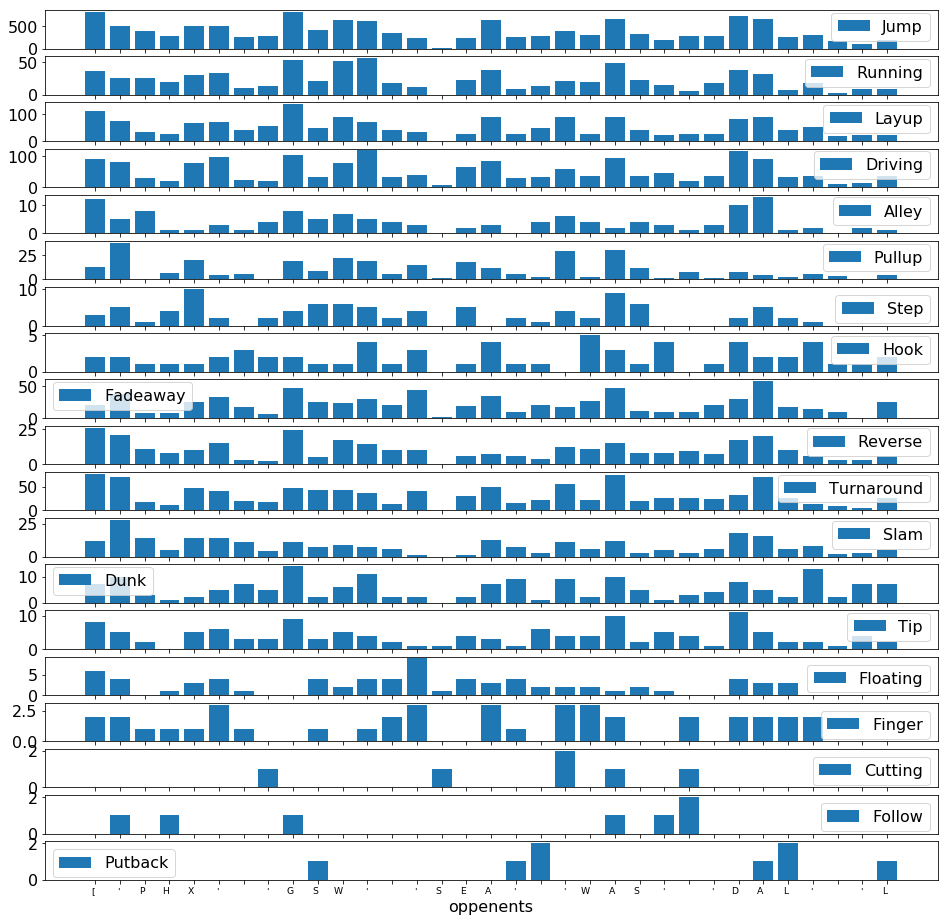

In [18]:
#action type v.s. opponent
plt.figure();
for i,act in enumerate(action):
    ActAttemptsWithOpp=np.zeros((len(opp)))
    for j,op in enumerate(opp):
        ActAttemptsWithOpp[j]=len(Traindata.loc[Traindata['action_first_words']==act][Traindata['opponent']==op])
    plt.subplot(len(action),1,i+1)
    plt.bar(np.arange(len(opp)),ActAttemptsWithOpp,label=act)
    plt.xticks(np.arange(len(opp)), str(opp), ha="right",fontsize='xx-small');
    plt.legend()
plt.xlabel('oppenents')

In [98]:
Traindata=pd.get_dummies(Traindata, columns=['opponent'])

his action types differ with different opponents, so we should put 'opponent' in needed features.

#### test data processing

In [69]:
allTest=pd.read_csv('test.csv')

In [70]:
x_test=allTest.copy()
x_test['shot_made_flag'][x_test['shot_made_flag'].isnull()]=0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
x_test['dist'] = np.sqrt(x_test['loc_x']**2 + x_test['loc_y']**2)
loc_x_zero = x_test['loc_x'] == 0
x_test['angle'] = np.array([0]*len(x_test))
x_test['angle'][~loc_x_zero] = np.arctan(x_test['loc_y'][~loc_x_zero] / x_test['loc_x'][~loc_x_zero])
x_test['angle'][loc_x_zero] = np.pi / 2 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [72]:
gaussianMixtureModel.fit(x_test.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
x_test['shotLocationCluster'] = gaussianMixtureModel.predict(x_test.loc[:,['loc_x','loc_y']])

In [73]:
x_test['secondsFromPeriodEnd']   = 60*x_test['minutes_remaining']+x_test['seconds_remaining']
x_test['secondsFromPeriodStart'] = 60*(11-x_test['minutes_remaining'])+(60-x_test['seconds_remaining'])
x_test['secondsFromGameStart']   = (x_test['period'] <= 4).astype(int)*(x_test['period']-1)*12*60 + (x_test['period'] > 4).astype(int)*((x_test['period']-5)*5*60 + 4*12*60) + x_test['secondsFromPeriodStart']
#x_test.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

In [99]:
x_test=pd.get_dummies(x_test, columns=['opponent'])

In [155]:
y_train=Traindata.action_type
#y_train=Traindata.act_ind

In [79]:
label_test=pd.read_csv('type_sample_submission.csv',names=['shot_id','action_type'])

In [156]:
label_test['act_ind']=label_test['action_type'].map(act_ind)
#y_test=label_test['act_ind']
y_test=label_test['action_type']

In [201]:
Traindata.columns

Index(['shot_id', 'action_type', 'lat', 'loc_x', 'loc_y', 'lon',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_zone_area', 'game_date', 'dist', 'angle', 'shotLocationCluster',
       'act_ind', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'action_first_words', 'opponent_ATL',
       'opponent_BKN', 'opponent_BOS', 'opponent_CHA', 'opponent_CHI',
       'opponent_CLE', 'opponent_DAL', 'opponent_DEN', 'opponent_DET',
       'opponent_GSW', 'opponent_HOU', 'opponent_IND', 'opponent_LAC',
       'opponent_MEM', 'opponent_MIA', 'opponent_MIL', 'opponent_MIN',
       'opponent_NJN', 'opponent_NOH', 'opponent_NOP', 'opponent_NYK',
       'opponent_OKC', 'opponent_ORL', 'opponent_PHI', 'opponent_PHX',
       'opponent_POR', 'opponent_SAC', 'opponent_SAS', 'opponent_SEA',
       'opponent_TOR', 'opponent_UTA', 'opponent_VAN', 'opponent_WAS'],
      dtype='object')

In [111]:
x_train_1=Traindata.copy()
x_train_1=x_train_1.drop(['action_type', 'shot_id','lat', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_1=x_test.copy()
x_test_1=x_test_1.drop(['shot_id','lat', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [157]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train_1,y_train)
y_pred_1=LR.predict(x_test_1)
LR.score(x_test_1,y_test)

0.5307817589576547

In [158]:
from sklearn.neighbors import KNeighborsClassifier
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_1,y_train)
KNC.score(x_test_1,y_test)

0.495114006514658

In [159]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
dtc.fit(x_train_1,y_train)
dtc.score(x_test_1,y_test)

0.5299674267100977

In [160]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(criterion='entropy',n_estimators=20,random_state=1,n_jobs=2)
RFC.fit(x_train_1,y_train)
RFC.score(x_test_1,y_test)

0.4998371335504886

In [181]:
from sklearn.neural_network import MLPClassifier
NNC=MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,3), random_state=1)
NNC.fit(x_train_1,y_train)
NNC.score(x_test_1,y_test)

0.6224755700325733

In [188]:
from sklearn import svm
SVC=svm.SVC()
SVC.fit(x_train_1,y_train)
SVC.score(x_test_1,y_test)

0.5299674267100977

In [ ]:
SVC_l=svm.SVC(kernel='linear')
SVC_l.fit(x_train_1,y_train)
SVC_l.score(x_test_1,y_test)

In [107]:
x_train_2=Traindata.copy()
x_train_2=x_train_2.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_2=x_test.copy()
x_test_2=x_test_2.drop(['shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [161]:
LR.fit(x_train_2,y_train)
y_pred_2=LR.predict(x_test_2)
LR.score(x_test_2,y_test)

0.5936482084690554

In [162]:
for k in [1,5,10,20,30,40,50]:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_score = knn.fit(x_train_2, y_train).\
        score(x_train_2, y_train)
    valid_score = knn.score(x_test_2, y_test)
    print('k: %d, Train/Valid Acc: %.3f/%.3f' %
          (k, train_score, valid_score))

k: 1, Train/Valid Acc: 0.999/0.360
k: 5, Train/Valid Acc: 0.696/0.481
k: 10, Train/Valid Acc: 0.655/0.558
k: 20, Train/Valid Acc: 0.620/0.614
k: 30, Train/Valid Acc: 0.615/0.620
k: 40, Train/Valid Acc: 0.614/0.622
k: 50, Train/Valid Acc: 0.613/0.622


In [163]:
dtc.fit(x_train_2, y_train)
dtc.score(x_test_2,y_test)

0.5299674267100977

In [150]:
RFC.fit(x_train_2,y_train)
RFC.score(x_test_2,y_test)

0.4982084690553746

In [182]:
NNC.fit(x_train_2,y_train)
NNC.score(x_test_2,y_test)

0.6224755700325733

In [125]:
x_train_3=Traindata.copy()
x_train_3=x_train_3.drop(['action_type', 'shot_id','lat', 'loc_x', 'loc_y', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date',
'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_3=x_test.copy()
x_test_3=x_test_3.drop(['shot_id','lat', 'loc_x', 'loc_y', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date',
'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [112]:
LR.fit(x_train_3,y_train)
y_pred_3=LR.predict(x_test_3)
LR.score(x_test_3,y_test)

0.49560260586319216

In [126]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_3,y_train)
KNC.score(x_test_3,y_test)

0.4995114006514658

In [135]:
dtc.fit(x_train_3, y_train)
dtc.score(x_test_3,y_test)

0.504071661237785

In [154]:
RFC.fit(x_train_3,y_train)
RFC.score(x_test_3,y_test)

0.49104234527687296

In [184]:
NNC.fit(x_train_3,y_train)
NNC.score(x_test_3,y_test)

0.6224755700325733

In [140]:
x_train_4=Traindata.copy()
x_train_4=x_train_4.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_4=x_test.copy()
x_test_4=x_test_4.drop(['shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [141]:
LR.fit(x_train_4,y_train)
y_pred_4=LR.predict(x_test_4)
LR.score(x_test_4,y_test)

0.49641693811074916

In [142]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_4,y_train)
KNC.score(x_test_4,y_test)

0.5100977198697069

In [143]:
dtc.fit(x_train_4, y_train)
dtc.score(x_test_4,y_test)

0.504885993485342

In [153]:
RFC.fit(x_train_4,y_train)
RFC.score(x_test_4,y_test)

0.48241042345276874

In [185]:
NNC.fit(x_train_4,y_train)
NNC.score(x_test_4,y_test)

0.6224755700325733

In [177]:
x_train_5=Traindata.copy()
x_train_5=x_train_5.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','action_first_words'], axis=1)

x_test_5=x_test.copy()
x_test_5=x_test_5.drop(['shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd'], axis=1)

In [172]:
LR.fit(x_train_5,y_train)
LR.score(x_test_5,y_test) 

0.609771986970684

In [178]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_5,y_train)
KNC.score(x_test_5,y_test)

0.6221498371335505

In [173]:
dtc.fit(x_train_5, y_train)
dtc.score(x_test_5,y_test)

0.5299674267100977

In [174]:
RFC.fit(x_train_5,y_train)
RFC.score(x_test_5,y_test)

0.5086319218241042

In [186]:
NNC.fit(x_train_5,y_train)
NNC.score(x_test_5,y_test)

0.6224755700325733

In [ ]:
x_train_6=Traindata.copy()
x_train_6=x_train_6.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','action_first_words'], axis=1)

x_test_6=x_test.copy()
x_test_6=x_test_6.drop(['shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance','game_date','dist', 'angle'
,'secondsFromPeriodEnd'], axis=1)